### set session

In [1]:
name = 'ANA1'
session = '20231211_d21'
num_trials = 143

### imports

In [2]:
from scipy import io
import numpy as np
import matplotlib.pyplot as plt
import statistics
import pandas as pd
import pickle
import glob # find files in a directory
import re # regex for string parsing

from common.set_matplotlib_settings import set_matplotlib_multiplot_settings
from common.load_tonedisc_matfile import load_tonedisc_matfile
from jerk.get_jerks import get_jerks
from jerk.calculate_minimum_jerk import solve_x_coefficients, minimum_jerk_function, smoothest_x_function, get_index_a_b, get_boundary_conditions

In [3]:
tone_discriminiation_matfile = '../Data_Copy/ToneDiscrimination/'+name+'/ToneDisc_'+name+'_'+session+'.mat'
params, response, respMTX, MTXTrialType = load_tonedisc_matfile(tone_discriminiation_matfile)

PreprocessLeverData_folder = "../Data_Copy/AnalysisData/"+name+"/PreprocessLeverData_"+name+"_"+session+"/"
HitMovements_folder = "../Data_Copy/AnalysisData/"+name+"/HitMovements_"+name+"_"+session+"/"
output_folder = "../Data_Copy/AnalysisData/"+name+"/Jerk_"+name+"_"+session+"/"

set_matplotlib_multiplot_settings()

respMTX shape: (143, 7)
MTXTrialType shape: (1000, 5)
number of trials: 143


for mac:

In [4]:
!mkdir {output_folder}

mkdir: ../Data_Copy/AnalysisData/ANA1/Jerk_ANA1_20231211_d21/: File exists


for windows:

In [5]:
!mkdir "{output_folder}"

mkdir: ../Data_Copy/AnalysisData/ANA1/Jerk_ANA1_20231211_d21/: File exists


### calculate jerks for all trials

In [6]:
get_jerks(num_trials, PreprocessLeverData_folder, output_folder)

### Find the peak of the movement

Find the index of the maximum value of leverdata in movement_trial#.npy

### Calculate the minimum jerk from start of movement to peak

1) $x(0)=x_0$
2) $v(0)=v_0$
3) $a(0)=a_0$ and 
4) $x(t_f)=x_f$
5) $v(t_f)=v_f$
6) $a(t_f)=a_f$


In [7]:
jerk_ratios = []
movement_informations = np.load(HitMovements_folder+"leverpress_informations.npy")
for movement_information in movement_informations:
    
    trial_index = int(movement_information[0])
    print("\nTrial:",trial_index)
    left_index, right_index = movement_information[1:]
    left_index = int(left_index)
    right_index = int(right_index)
    index_a, index_b = get_index_a_b(trial_index, left_index, right_index, PreprocessLeverData_folder)
    x_0, v_0, a_0, x_f, v_f, a_f, tf = get_boundary_conditions(index_a, index_b, trial_index, PreprocessLeverData_folder, output_folder)

    smoothest_x_coefficients = solve_x_coefficients(x_0, v_0, a_0, x_f, v_f, a_f, tf)
    t_input = np.linspace(0, tf, index_b - index_a)
    print("smoothest x sampling frequency: ", 1/ (np.median(np.diff(t_input))))
    smoothest_x = smoothest_x_function(smoothest_x_coefficients, t_input)

    jerk = np.load(output_folder+"jerk_trial"+str(trial_index)+".npy")
    abs_jerk = np.abs(jerk)
    sample_times = np.fromfile(PreprocessLeverData_folder+"sample_times_trial"+str(trial_index)+".bin", dtype=np.double)
    actual_jerk_dx = np.median(np.diff(sample_times))
    actual_cumulative_jerk = np.trapz(abs_jerk[index_a:index_b], dx=actual_jerk_dx)

    minimum_jerk = minimum_jerk_function(smoothest_x_coefficients, t_input)
    minimum_jerk = np.array(minimum_jerk, dtype=float)
    abs_minimum_jerk = np.abs(minimum_jerk)
    minimum_jerk_dx = np.median(np.diff(t_input))
    minimum_cumulative_jerk = np.trapz(abs_minimum_jerk, dx=minimum_jerk_dx)

    jerk_ratio = actual_cumulative_jerk / minimum_cumulative_jerk
    jerk_ratios.append([trial_index, jerk_ratio, actual_cumulative_jerk, minimum_cumulative_jerk])

    print("Minimum Cumulative Jerk:", str(minimum_cumulative_jerk))
    print("Actual Cumulative Jerk:",str(actual_cumulative_jerk))
    print("Jerk Ratio (Actual/Minimum):", jerk_ratio)

jerk_ratios = np.array(jerk_ratios)
np.save(output_folder+"jerk_ratios", jerk_ratios)


Trial: 0
x_0: 3.0333400791140672 v_0: 2.659238457551899 a_0: -159.09086621910532 x_f: 3.4042542025203493 v_f: -0.12200473670127851 a_f: -865.102281733137
tf: 0.11474273193424889 s
Solution for the coefficients:
C1: -165691.591155847
C2: 29002.4391343491
C3: -409.543926257240
C4: -79.5454331095525
C5: 2.65923845755190
C6: 3.03334007911407
smoothest x sampling frequency:  5874.01039384544
Minimum Cumulative Jerk: 1517.3039854777398
Actual Cumulative Jerk: 4809.307994761477
Jerk Ratio (Actual/Minimum): 3.1696403890003713

Trial: 1
x_0: 3.033251667191422 v_0: 2.145078875021576 a_0: 347.8741297216599 x_f: 3.0732251335068206 v_f: -0.09378436666506572 a_f: -615.5149008081534
tf: 0.015978639963927677 s
Solution for the coefficients:
C1: 17785544.4248992
C2: -698142.993513057
C3: -2874.46869376350
C4: 173.937064860830
C5: 2.14507887502158
C6: 3.03325166719142
smoothest x sampling frequency:  5820.2700736702545
Minimum Cumulative Jerk: 963.305138500454
Actual Cumulative Jerk: 962.8076993486821


In [8]:
jerk_ratios[:,0]

array([  0.,   1.,   3.,   4.,   5.,   6.,   8.,   9.,  10.,  11.,  12.,
        13.,  14.,  18.,  19.,  20.,  21.,  22.,  24.,  25.,  26.,  27.,
        29.,  31.,  33.,  35.,  39.,  40.,  41.,  42.,  43.,  45.,  46.,
        47.,  48.,  49.,  50.,  52.,  53.,  54.,  55.,  59.,  62.,  67.,
        68.,  70.,  71.,  74.,  76.,  78.,  79.,  80.,  81.,  82.,  83.,
        84.,  85.,  86.,  89.,  93.,  94.,  95.,  96., 100., 101., 103.,
       105., 107., 109., 110., 111., 113., 114., 115., 116., 117., 118.,
       119., 120., 121., 122., 123., 124., 125., 126., 127., 128., 129.,
       130., 131., 132., 133., 134., 135., 136., 137., 138., 139., 140.,
       141., 142.])

### Plot single jerk

x_0: 3.0333400791140672 v_0: 2.659238457551899 a_0: -159.09086621910532 x_f: 3.4042542025203493 v_f: -0.12200473670127851 a_f: -865.102281733137
tf: 0.11474273193424889 s
Solution for the coefficients:
C1: -165691.591155847
C2: 29002.4391343491
C3: -409.543926257240
C4: -79.5454331095525
C5: 2.65923845755190
C6: 3.03334007911407
smoothest x sampling frequency:  5874.01039384544
Minimum Cumulative Jerk: 1517.3039854777398
Actual Cumulative Jerk^2: 4809.307994761477
jerk ratio actual/minimum: 3.1696403890003713


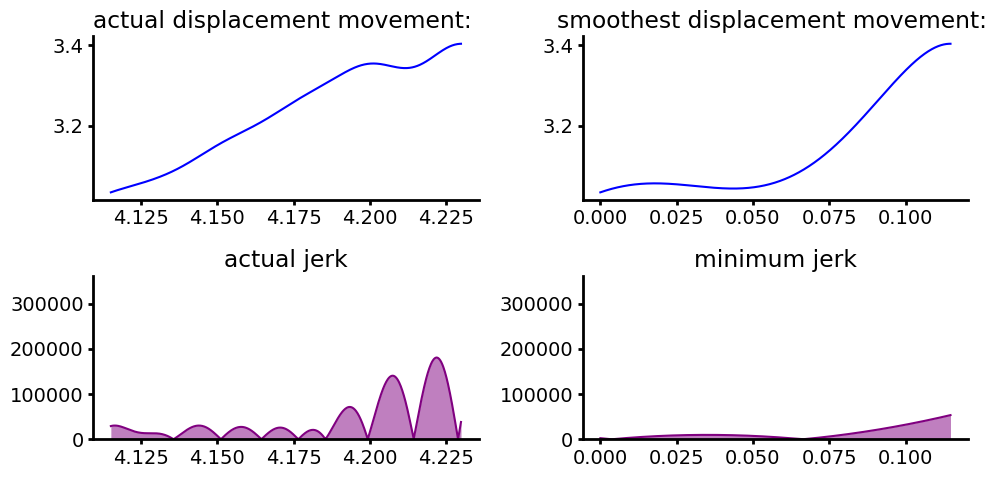

In [9]:
movement_information = movement_informations[0]
trial_index = int(movement_information[0])

left_index, right_index = movement_information[1:]
left_index = int(left_index)
right_index = int(right_index)
index_a, index_b = get_index_a_b(trial_index, left_index, right_index, PreprocessLeverData_folder)
x_0, v_0, a_0, x_f, v_f, a_f, tf = get_boundary_conditions(index_a, index_b, trial_index, PreprocessLeverData_folder, output_folder)

smoothest_x_coefficients = solve_x_coefficients(x_0, v_0, a_0, x_f, v_f, a_f, tf)
t_input = np.linspace(0, tf, index_b - index_a)
print("smoothest x sampling frequency: ", 1/ (np.median(np.diff(t_input))))
smoothest_x = smoothest_x_function(smoothest_x_coefficients, t_input)

jerk = np.load(output_folder+"jerk_trial"+str(trial_index)+".npy")
abs_jerk = np.abs(jerk)
leverdata = np.fromfile(PreprocessLeverData_folder+"processed_trial"+str(trial_index)+".bin", dtype=np.double)
sample_times = np.fromfile(PreprocessLeverData_folder+"sample_times_trial"+str(trial_index)+".bin", dtype=np.double)
actual_jerk_dx = np.median(np.diff(sample_times))
actual_cumulative_jerk = np.trapz(abs_jerk[index_a:index_b], dx=actual_jerk_dx)

minimum_jerk = minimum_jerk_function(smoothest_x_coefficients, t_input)
minimum_jerk = np.array(minimum_jerk, dtype=float)
abs_minimum_jerk = np.abs(minimum_jerk)
minimum_jerk_dx = np.median(np.diff(t_input))
minimum_cumulative_jerk = np.trapz(abs_minimum_jerk, dx=minimum_jerk_dx)

jerk_ratio = actual_cumulative_jerk / minimum_cumulative_jerk

print("Minimum Cumulative Jerk:", str(minimum_cumulative_jerk))
print("Actual Cumulative Jerk^2:",str(actual_cumulative_jerk))
print("jerk ratio actual/minimum:", jerk_ratio)

plt.subplot(2,2,1)
plt.plot(sample_times[index_a:index_b], leverdata[index_a:index_b], color='blue')
plt.title("actual displacement movement: ")

plt.subplot(2,2,2)
plt.plot(t_input, smoothest_x, color='blue')
plt.title("smoothest displacement movement: ")

plt.subplot(2, 2, 3)
plt.plot(sample_times[index_a:index_b], abs_jerk[index_a:index_b], color='purple')
plt.fill_between(sample_times[index_a:index_b], 0, abs_jerk[index_a:index_b], color='purple', alpha=0.5, linewidth=0.0)
plt.ylim([0, max(abs_jerk[index_a:index_b])*2])
plt.title("actual jerk")

plt.subplot(2, 2, 4)
plt.plot(t_input, abs_minimum_jerk, color='purple')
plt.fill_between(t_input, 0, abs_minimum_jerk, color='purple', alpha=0.5, zorder=2, linewidth=0.0)
plt.ylim([0, max(abs_jerk[index_a:index_b])*2])
plt.title("minimum jerk")

plt.show()

### Calculate the minimum jerk from peak to end of movement